In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
test_path = 'gdrive/My Drive/Colab Notebooks/NoahTrim_Proper.csv'

from sklearn.model_selection import train_test_split
import pandas as pd
import glob

from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
import math
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)

Mounted at /content/gdrive


In [ ]:
!pip install interpret
from interpret import show
from interpret.blackbox import LimeTabular

  Using cached interpret-0.2.7-py3-none-any.whl (1.4 kB)
  Using cached interpret_core-0.2.7-py3-none-any.whl (6.6 MB)
     |████████████████████████████████| 756 kB 14.7 MB/s 
     |████████████████████████████████| 131 kB 55.3 MB/s 
ERROR: Operation cancelled by user


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-a362bf957358>", line 2, in <module>
    from interpret import show
ModuleNotFoundError: No module named 'interpret'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python3.7/inspect.py", line 1502, in getinnerframes
   

ModuleNotFoundError: ignored

In [ ]:

path = 'gdrive/My Drive/Colab Notebooks/'
all_files = {
    
     "p1": "p1.csv",
     "p2": "p2.csv",
     "p3": "p3.csv",
     "p4": "p4.csv",
     "p5": "p5.csv",
     "p6": "p6.csv",
     "p7": "p7.csv",
     "p8": "p8.csv",
     "p9": "p9.csv",
     "p10": "p10.csv"

}

li = []

for alias in all_files:
    temp_df = pd.read_csv(path+all_files[alias], index_col=None, header=0)
    temp_df["file_id"] = alias
    li.append(temp_df)

    kp_names = [
      'nose',
      'left_eye',
      'right_eye',
      'left_ear',
      'right_ear',
      'left_shoulder',
      'right_shoulder',
      'left_elbow',
      'right_elbow',
      'left_wrist',
      'right_wrist',
      'left_hip',
      'right_hip',
      'left_knee',
      'right_knee',
      'left_ankle',
      'right_ankle',
    ]

    colnames = []
    for cam in ["back", "side"]:
      for i in kp_names:
        for pt in ["x", "y", "z"]:
          colnames.append(f"{cam}_{i}_{pt}")
    colnames = ["frame_count"] + colnames + ["label", "file_id"]
    temp_df.columns = colnames

df = pd.concat(li, axis=0, ignore_index=True)
dftest = df.apply(lambda x : True
            if x['label'] == 1 else False, axis = 1)

num_rows = len(dftest[dftest == True].index)

print(num_rows)
df

# Splitting up the Dataset

In [ ]:
X = df[[c for c in df.columns if c not in ("frame_count","label", "file_id")]]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)#test set #train_test_split from sklearn by default shuffles the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)#train set (20% from 80% validation)

In [ ]:
for c in X_train.columns: print(c)

# Creating the Custom Transformers

In [ ]:
def calcAngle(x1,y1,x2,y2):
  angles = []
  for i in range(len(x1)):
    angles.append(math.atan2(y2[i] - y1[i], x2[i] - x1[i]) * 180/math.pi)
  return angles

class FeatureEngineeringTransformer():
  def __init__(self):
    self.angles_joints = {
        'left_torso': ('left_hip','left_shoulder'),
        'right_torso': ('right_hip','right_shoulder'),
        'left_ulna': ('left_wrist','left_elbow'),
        'right_ulna': ('right_wrist','right_elbow'),
        'left_los': ('left_eye','nose'),#line of sight
        'right_los': ('right_eye','nose')
    }

  def fit(self,x, y=None):
    return self

  def transform(self,x):
    for angle in self.angles_joints:
      joint1, joint2 = self.angles_joints[angle]
      x[f'back_{angle}_angle'] = calcAngle(
          x1 = x[f'back_{joint1}_x'].values,
          y1 = x[f'back_{joint1}_y'].values,
          x2 = x[f'back_{joint2}_x'].values,
          y2 = x[f'back_{joint2}_y'].values
      )
      x[f'side_{angle}_angle'] = calcAngle(
          x1 = x[f'side_{joint1}_x'].values,
          y1 = x[f'side_{joint1}_y'].values,
          x2 = x[f'side_{joint2}_x'].values,
          y2 = x[f'side_{joint2}_y'].values
      )
    return x

class FeatureSelectionTransformer():
  def __init__(self, mode):
    self.mode = mode
  
  def fit(self,x, y=None):
    return self
  
  def transform(self, x, y=None):
    if self.mode == "back":
      cols_to_drop = [c for c in x.columns if "side_" in c]
    elif self.mode == "side":
      cols_to_drop = [c for c in x.columns if "back_" in c]
    elif self.mode == "combined":
      cols_to_drop = []
    
    x = x[[c for c in x.columns if c not in cols_to_drop]]
    return x

df


# Creating the Pipeline

In [ ]:
results = {}

for dataset in ["combined", "back", "side"]:
  for engineering in [True, False]:
    for model in ["SVM", "LR", "RF", "NN"]:
      pipeline_name = f"{dataset}_{'engTrue' if engineering else 'engFalse'}_{model}"
      print(pipeline_name)
      pipeline_steps = []
      if engineering:
        pipeline_steps.append(('eng', FeatureEngineeringTransformer()))
      
      pipeline_steps.append(('sel', FeatureSelectionTransformer(dataset)))
      pipeline_steps.append(('scale', StandardScaler()))
      
      
      if model == "SVM":
        params={
            'C':[0.1,1],
            'kernel':['poly','linear'],
            'gamma': ['scale', 'auto']
        }
        classifier_svm = svm.SVC()
        clf = GridSearchCV(classifier_svm, param_grid=params)

      elif model == "LR":
        params={
            'C':[0.1,1,10],
            'penalty':['none', 'l2']
        }
        LR = LogisticRegression(max_iter=2000)
        clf = GridSearchCV(LR, param_grid=params)

      elif model == "RF":
          params={ 
          'n_estimators':[120,140],
          'min_samples_split':[3,4,5],
          'max_depth': [3,4]
          }
          RN = RandomForestClassifier()
          clf=GridSearchCV(RN,param_grid=params)

      elif model == "NN":
        parameters = {'batch_size': [8,16,32, 64], 'hidden_layer_sizes' : [(50,), (100,) , (200,)], 'early_stopping': [True]}
        MLP = MLPClassifier(random_state=1, max_iter=500)
        clf = GridSearchCV(MLP, parameters)
        #clf = MLPClassifier(random_state=1, max_iter=500, batch_size=32, hidden_layer_sizes=(100,))
      pipeline_steps.append(('clf', clf))

      temp_pipeline = Pipeline(pipeline_steps).fit(X_train.copy(), y_train.copy())

      y_pred = temp_pipeline.predict(X_val.copy())#X_test
      y_predtest = temp_pipeline.predict(X_test.copy()) 
      results[pipeline_name] = {
          'model': model,
          'dataset': dataset,
          'feature_engineering': engineering,
          'pipeline': temp_pipeline,
          'accuracy': accuracy_score(y_val, y_pred) * 100,
          'F1': f1_score(y_val,y_pred) * 100, #y-test instead of y val in test set
          'test_accuracy': accuracy_score(y_test, y_predtest) * 100,
          'F1_test': f1_score(y_test,y_predtest) * 100
      }

      with open('gdrive/MyDrive/Colab Notebooks/Pipelines_Latest/'+pipeline_name+'.pkl', 'wb') as file:
        pickle.dump(temp_pipeline,file)

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/Pipelines_Latest/back_engFalse_RF.pkl', 'rb') as file:
        model_side = pickle.load(file)

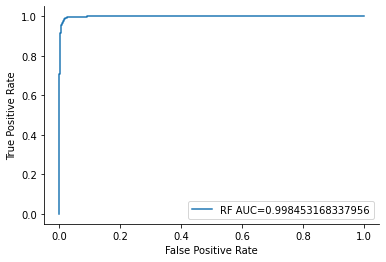

In [ ]:
y_predtest = model_side.predict(X_test.copy()) 
#y_pred = model_side.predict(X)
accuracy = accuracy_score(y_test, y_predtest)

y_pred_proba = model_side.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="RF AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
#f1_score(y_pred,y)

[[ 955  249]
 [  29 1170]]


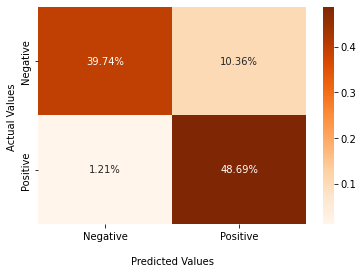

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1204
           1       0.82      0.98      0.89      1199

    accuracy                           0.88      2403
   macro avg       0.90      0.88      0.88      2403
weighted avg       0.90      0.88      0.88      2403



In [ ]:
y_predtest = model_side.predict(X_test.copy()) 
cf_matrix = confusion_matrix(y_test, y_predtest)
print(cf_matrix)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Oranges')
#ax.set_title('back_engFalse_LR\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])
plt.show()

print(classification_report(y_test, y_predtest))

In [ ]:
y_predtest = model_side.predict(X_test.copy()) 
ps = precision_score(y_test, y_predtest)
print(ps)
rs = recall_score(y_test, y_predtest)
print(rs)

0.8883895131086142
0.9891576313594662


In [ ]:

results_df = pd.DataFrame(results).drop(['pipeline', 'feature_engineering']).transpose().sort_values(["model","test_accuracy"], ascending=False)
results_df

,model,dataset,accuracy,F1,test_accuracy,F1_test
combined_engTrue_SVM,SVM,combined,97.294485,97.322348,97.58635,97.628782
combined_engFalse_SVM,SVM,combined,97.294485,97.325103,97.419892,97.469388
side_engTrue_SVM,SVM,side,96.35796,96.380558,97.170204,97.213115
side_engFalse_SVM,SVM,side,96.35796,96.391753,96.837287,96.892886
back_engFalse_SVM,SVM,back,93.756504,94.023904,93.383271,93.722858
back_engTrue_SVM,SVM,back,93.236212,93.525896,93.258427,93.606946
combined_engTrue_RF,RF,combined,94.120708,94.272681,94.340408,94.498382
side_engTrue_RF,RF,side,93.028096,93.252769,92.467749,92.791716
combined_engFalse_RF,RF,combined,92.351717,92.704715,91.968373,92.356436
side_engFalse_RF,RF,side,91.831426,92.223873,90.886392,91.374557


In [ ]:
resultsRF = {}

for dataset in ["combined", "back", "side"]:
  for engineering in [True, False]:
    for model in ["RF"]:
      pipeline_name = f"{dataset}_{'engTrue' if engineering else 'engFalse'}_{model}"
      print(pipeline_name)
      pipeline_steps = []
      if engineering:
        pipeline_steps.append(('eng', FeatureEngineeringTransformer()))
      
      pipeline_steps.append(('sel', FeatureSelectionTransformer(dataset)))
      pipeline_steps.append(('scale', StandardScaler()))
      

      if model == "RF":
          params={ 
          'n_estimators':[120,140],
          'min_samples_split':[3,4,5],
          'max_depth': [3,4]
          }
          RN = RandomForestClassifier()
          clf=GridSearchCV(RN,param_grid=params)
      pipeline_steps.append(('clf', clf))

      temp_pipeline = Pipeline(pipeline_steps).fit(X_train.copy(), y_train.copy())

      y_pred = temp_pipeline.predict(X_val.copy())#X_test
      y_predtest = temp_pipeline.predict(X_test.copy()) 
      resultsRF[pipeline_name] = {
          'model': model,
          'dataset': dataset,
          'feature_engineering': engineering,
          'pipeline': temp_pipeline,
          'accuracy': accuracy_score(y_val, y_pred) * 100,
          'F1': f1_score(y_val,y_pred) * 100, #y-test instead of y val in test set
          'test_accuracy': accuracy_score(y_test, y_predtest) * 100,
          'F1_test': f1_score(y_test,y_predtest) * 100
      }

      with open('gdrive/MyDrive/Colab Notebooks/pipelineRFonly/'+pipeline_name+'.pkl', 'wb') as file:
        pickle.dump(temp_pipeline,file)

combined_engTrue_RF
combined_engFalse_RF
back_engTrue_RF
back_engFalse_RF
side_engTrue_RF
side_engFalse_RF


In [ ]:
#results_df = pd.DataFrame(results).drop(['pipeline']).transpose().sort_values(["accuracy","F1"], ascending=False)
results_df = pd.DataFrame(results).drop(['pipeline', 'feature_engineering']).transpose().sort_values(["accuracy"], ascending=False)
results_df

NameError: ignored

In [ ]:
resultsSVM = {}

for dataset in ["combined", "back", "side"]:
  for engineering in [True, False]:
    for model in ["SVM"]:
      pipeline_name = f"{dataset}_{'engTrue' if engineering else 'engFalse'}_{model}"
      print(pipeline_name)
      pipeline_steps = []
      if engineering:
        pipeline_steps.append(('eng', FeatureEngineeringTransformer()))
      
      pipeline_steps.append(('sel', FeatureSelectionTransformer(dataset)))
      pipeline_steps.append(('scale', StandardScaler()))
      

      if model == "SVM":
        params={
            'C':[0.1,1],
            'kernel':['poly','linear'],
            'gamma': ['scale', 'auto']
        }
        classifier_svm = svm.SVC()
        clf = GridSearchCV(classifier_svm, param_grid=params)
      pipeline_steps.append(('clf', clf))

      temp_pipeline = Pipeline(pipeline_steps).fit(X_train.copy(), y_train.copy())

      y_pred = temp_pipeline.predict(X_val.copy())#X_test
      y_predtest = temp_pipeline.predict(X_test.copy()) 
      resultsSVM[pipeline_name] = {
          'model': model,
          'dataset': dataset,
          'feature_engineering': engineering,
          'pipeline': temp_pipeline,
          'accuracy': accuracy_score(y_val, y_pred) * 100,
          'F1': f1_score(y_val,y_pred) * 100, #y-test instead of y val in test set
          'test_accuracy': accuracy_score(y_test, y_predtest) * 100,
          'F1_test': f1_score(y_test,y_predtest) * 100
      }

      with open('gdrive/MyDrive/Colab Notebooks/pipelineSVMonly/'+pipeline_name+'.pkl', 'wb') as file:
        pickle.dump(temp_pipeline,file)

combined_engTrue_SVM
combined_engFalse_SVM
back_engTrue_SVM
back_engFalse_SVM
side_engTrue_SVM
side_engFalse_SVM


In [ ]:
results_df = pd.DataFrame(resultsSVM).drop(['pipeline']).transpose().sort_values(["accuracy"], ascending=False)
results_df

NameError: ignored

In [ ]:
resultsNN = {}

for dataset in ["combined", "back", "side"]:
  for engineering in [True, False]:
    for model in ["NN"]:
      pipeline_name = f"{dataset}_{'engTrue' if engineering else 'engFalse'}_{model}"
      print(pipeline_name)
      pipeline_steps = []
      if engineering:
        pipeline_steps.append(('eng', FeatureEngineeringTransformer()))
      
      pipeline_steps.append(('sel', FeatureSelectionTransformer(dataset)))
      pipeline_steps.append(('scale', StandardScaler()))
      

      if model == "NN":
        parameters = {'batch_size': [8,16,32, 64], 'hidden_layer_sizes' : [(50,), (100,) , (200,)], 'early_stopping': [True]}
        MLP = MLPClassifier(random_state=1, max_iter=500)
        clf = GridSearchCV(MLP, parameters)
        #clf = MLPClassifier(random_state=1, max_iter=500, batch_size=32, hidden_layer_sizes=(100,))
      pipeline_steps.append(('clf', clf))

      temp_pipeline = Pipeline(pipeline_steps).fit(X_train.copy(), y_train.copy())

      y_pred = temp_pipeline.predict(X_val.copy())#X_test
      y_predtest = temp_pipeline.predict(X_test.copy()) 
      resultsNN[pipeline_name] = {
          'model': model,
          'dataset': dataset,
          'feature_engineering': engineering,
          'pipeline': temp_pipeline,
          'accuracy': accuracy_score(y_val, y_pred) * 100,
          'F1': f1_score(y_val,y_pred) * 100, #y-test instead of y val in test set
          'test_accuracy': accuracy_score(y_test, y_predtest) * 100,
          'F1_test': f1_score(y_test,y_predtest) * 100
      }

      with open('gdrive/MyDrive/Colab Notebooks/pipelineNNonly/'+pipeline_name+'.pkl', 'wb') as file:
        pickle.dump(temp_pipeline,file)

combined_engTrue_NN
combined_engFalse_NN
back_engTrue_NN
back_engFalse_NN
side_engTrue_NN
side_engFalse_NN


In [ ]:
results_df = pd.DataFrame(resultsNN).drop(['pipeline']).transpose().sort_values(["accuracy"], ascending=False)
results_df


,model,dataset,feature_engineering,accuracy,F1,test_accuracy,F1_test
combined_engTrue_NN,NN,combined,True,98.335068,98.335068,98.293799,98.303682
combined_engFalse_NN,NN,combined,False,98.126951,98.117155,98.501873,98.502496
side_engFalse_NN,NN,side,False,97.814776,97.803347,98.044112,98.04085
back_engFalse_NN,NN,back,False,97.60666,97.599165,97.66958,97.664721
side_engTrue_NN,NN,side,True,97.554631,97.540555,97.711194,97.705465
back_engTrue_NN,NN,back,True,97.450572,97.449245,97.461506,97.472027


# Test Set

In [ ]:
df.loc[X_test.index]

,frame_count,back_nose_x,back_nose_y,back_nose_z,back_left_eye_x,back_left_eye_y,back_left_eye_z,back_right_eye_x,back_right_eye_y,back_right_eye_z,back_left_ear_x,back_left_ear_y,back_left_ear_z,back_right_ear_x,back_right_ear_y,back_right_ear_z,back_left_shoulder_x,back_left_shoulder_y,back_left_shoulder_z,back_right_shoulder_x,back_right_shoulder_y,back_right_shoulder_z,back_left_elbow_x,back_left_elbow_y,back_left_elbow_z,back_right_elbow_x,back_right_elbow_y,back_right_elbow_z,back_left_wrist_x,back_left_wrist_y,back_left_wrist_z,back_right_wrist_x,back_right_wrist_y,back_right_wrist_z,back_left_hip_x,back_left_hip_y,back_left_hip_z,back_right_hip_x,back_right_hip_y,back_right_hip_z,back_left_knee_x,back_left_knee_y,back_left_knee_z,back_right_knee_x,back_right_knee_y,back_right_knee_z,back_left_ankle_x,back_left_ankle_y,back_left_ankle_z,back_right_ankle_x,back_right_ankle_y,back_right_ankle_z,side_nose_x,side_nose_y,side_nose_z,side_left_eye_x,side_left_eye_y,side_left_eye_z,side_right_eye_x,side_right_eye_y,side_right_eye_z,side_left_ear_x,side_left_ear_y,side_left_ear_z,side_right_ear_x,side_right_ear_y,side_right_ear_z,side_left_shoulder_x,side_left_shoulder_y,side_left_shoulder_z,side_right_shoulder_x,side_right_shoulder_y,side_right_shoulder_z,side_left_elbow_x,side_left_elbow_y,side_left_elbow_z,side_right_elbow_x,side_right_elbow_y,side_right_elbow_z,side_left_wrist_x,side_left_wrist_y,side_left_wrist_z,side_right_wrist_x,side_right_wrist_y,side_right_wrist_z,side_left_hip_x,side_left_hip_y,side_left_hip_z,side_right_hip_x,side_right_hip_y,side_right_hip_z,side_left_knee_x,side_left_knee_y,side_left_knee_z,side_right_knee_x,side_right_knee_y,side_right_knee_z,side_left_ankle_x,side_left_ankle_y,side_left_ankle_z,side_right_ankle_x,side_right_ankle_y,side_right_ankle_z,label,file_id
6450,450,0.392435,0.503619,0.324805,0.386459,0.496540,0.445149,0.384385,0.506167,0.363654,0.388993,0.490443,0.528893,0.389505,0.520426,0.447023,0.426167,0.455850,0.438063,0.430199,0.573071,0.501499,0.480275,0.452348,0.169790,0.469496,0.617431,0.448180,0.417624,0.488384,0.307088,0.410051,0.559286,0.300925,0.595340,0.487263,0.622524,0.593720,0.584517,0.574573,0.795302,0.432664,0.675512,0.810144,0.572604,0.640364,0.974311,0.389712,0.816839,0.990348,0.569470,0.747899,0.369641,0.576656,0.490596,0.364599,0.579827,0.419588,0.357922,0.579381,0.357054,0.347458,0.579749,0.561075,0.338753,0.572335,0.528129,0.346897,0.508289,0.503797,0.341897,0.537064,0.672167,0.483481,0.548245,0.315172,0.471125,0.572813,0.579917,0.444536,0.598510,0.209668,0.424411,0.606147,0.373496,0.543220,0.364784,0.746115,0.542463,0.399270,0.781144,0.730526,0.374058,0.614358,0.746238,0.510633,0.626723,0.896815,0.395683,0.768978,0.956245,0.538535,0.829684,0,karla
1098,1099,0.315684,0.508109,0.458390,0.310114,0.497025,0.522256,0.313348,0.519982,0.445994,0.312844,0.496430,0.547215,0.316065,0.545204,0.564745,0.333447,0.471409,0.669839,0.366467,0.614221,0.678959,0.462348,0.483994,0.202908,0.482088,0.602226,0.430615,0.440970,0.498343,0.111080,0.572903,0.480522,0.257953,0.541603,0.544435,0.681516,0.545730,0.642081,0.843072,0.792180,0.471201,0.418311,0.796647,0.644756,0.560501,0.993732,0.461708,0.659219,0.990090,0.635367,0.584387,0.270633,0.558978,0.556558,0.257697,0.558385,0.584984,0.254569,0.568802,0.593573,0.220056,0.541765,0.603552,0.216307,0.553108,0.668788,0.236112,0.469904,0.580041,0.224206,0.523900,0.718267,0.386125,0.457695,0.294610,0.379686,0.566876,0.856886,0.480563,0.530437,0.186926,0.497336,0.607580,0.764375,0.480347,0.367457,0.843200,0.485355,0.402846,0.835110,0.705661,0.356296,0.785042,0.743721,0.431663,0.758679,0.877055,0.352480,0.584429,0.963066,0.380807,0.759024,0,noah
7988,786,0.301213,0.498955,0.468155,0.288069,0.486168,0.544215,0.286276,0.509131,0.603395,0.300255,0.465242,0.689677,0.294729,0.525973,0.582575,0.368927,0.427213,0.762213,0.363722,0.566518,0.787494,0.489600,0.419556,0.462184,0.482997,0.595698,0.667907,0.501719,0.504452,0.259241,0.496018,0.559961,0.2267

# Feature Importance

In [ ]:
from interpret.blackbox import LimeTabular
from interpret import show

In [ ]:
test = results['side_engFalse_NN']['pipeline']
lime = LimeTabular(predict_fn=test.predict_proba, data=X_train.copy())

AttributeError: ignored

In [ ]:
results['side_engFalse_NN']['pipeline'].named_steps

{'sel': <__main__.FeatureSelectionTransformer at 0x7ff0cd5eea50>,
 'scale': StandardScaler(),
 'clf': MLPClassifier(batch_size=32, max_iter=500, random_state=1)}

In [ ]:
test_pipeline = results['side_engFalse_NN']['pipeline']
test_model = test_pipeline.named_steps['clf']
input_data = test_pipeline.named_steps['sel'].transform(X_train)
fnames = input_data.columns
input_data = test_pipeline.named_steps['scale'].transform(input_data)
lime = LimeTabular(predict_fn=test_model.predict_proba, data=input_data)

In [ ]:
lime_local = lime.explain_local(input_data[4:5], input_data[4:5])

In [ ]:
show(lime_local)

In [ ]:
fnames[34]

'side_left_hip_y'